tensor([[2.0670],
        [3.7330],
        [2.7471],
        [3.1882],
        [1.9391],
        [2.3515],
        [3.0251],
        [2.8702],
        [3.6857],
        [2.8476],
        [2.8333],
        [3.2526],
        [2.7323],
        [1.3885],
        [2.7078],
        [1.4473],
        [3.7928],
        [1.8866],
        [1.5642],
        [3.4604],
        [3.7301],
        [3.0644],
        [3.1506],
        [2.4177],
        [2.5437],
        [2.6588],
        [6.5361],
        [4.0695],
        [6.7813],
        [3.2670],
        [2.1092],
        [1.5292],
        [1.4395],
        [3.0117],
        [2.7602],
        [2.4636],
        [3.1665],
        [1.7820],
        [2.5028],
        [2.8910],
        [2.2958],
        [4.6611],
        [2.3123],
        [4.4075],
        [3.5002],
        [2.5629],
        [8.7509],
        [2.6411],
        [2.4556],
        [3.3385],
        [2.3853],
        [2.5271],
        [2.8170],
        [2.1249],
        [2.7223],
        [2

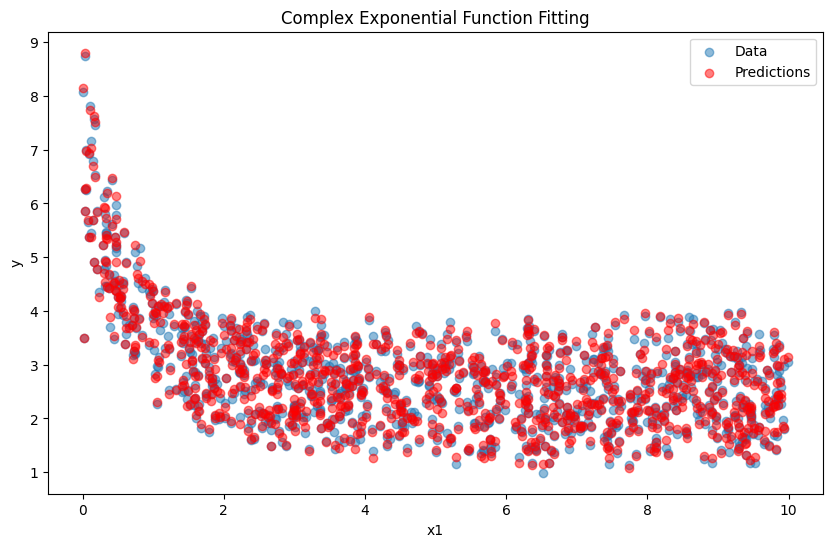

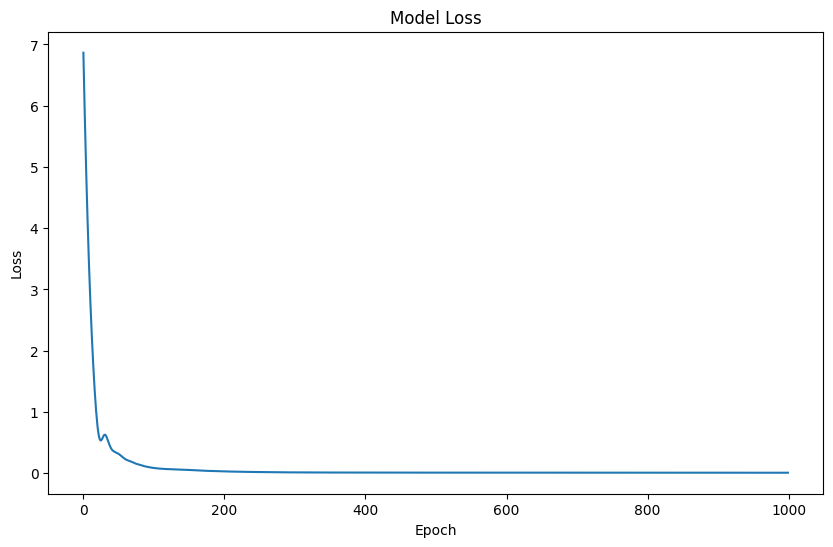


샘플 데이터에 대한 추정된 a1, a2, a3 값:
Sample 1: a1 = 2.5703, a2 = 0.8425, a3 = 2.0600
Sample 2: a1 = 3.3921, a2 = 1.6142, a3 = 2.5095
Sample 3: a1 = 3.4722, a2 = 1.5577, a3 = 2.8262
Sample 4: a1 = 5.6494, a2 = 1.0956, a3 = 3.1136
Sample 5: a1 = 5.1073, a2 = 1.5607, a3 = 1.8933


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성 함수
def generate_data(num_samples=1000):
    x1 = np.random.uniform(0, 10, num_samples)
    x2 = np.random.uniform(0, 5, num_samples)
    x3 = np.random.uniform(0, 5, num_samples)
    x4 = np.random.uniform(0, 5, num_samples)
    x5 = np.random.uniform(0, 5, num_samples)
    
    # a1, a2, a3를 x2, x3, x4, x5의 함수로 정의 (예시)
    a1 = 2 + 0.5*x2 + 0.3*x3
    a2 = 0.5 + 0.1*x3 + 0.2*x4
    a3 = 1 + 0.2*x4 + 0.4*x5
    
    y = a1 * np.exp(-a2 * x1) + a3 + np.random.normal(0, 0.1, num_samples)
    
    return x1, x2, x3, x4, x5, y

# 신경망 모델 정의
class ComplexExponentialModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        x1 = x[:, 0].unsqueeze(1)
        x_rest = x[:, 1:]
        
        a1, a2, a3 = self.hidden(x_rest).chunk(3, dim=1)
        
        # a1과 a2는 항상 양수여야 하므로 exp 함수 사용
        a1 = torch.exp(a1)
        a2 = torch.exp(a2)
        
        return a1 * torch.exp(-a2 * x1) + a3

# 데이터 생성 및 전처리
x1, x2, x3, x4, x5, y = generate_data()
X = np.column_stack((x1, x2, x3, x4, x5))

X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).unsqueeze(1)

print(y_tensor)

# 모델, 손실 함수, 옵티마이저 초기화
model = ComplexExponentialModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 1000
losses = []

for epoch in range(num_epochs):
    # 순전파
    y_pred = model(X_tensor)
    loss = criterion(y_pred, y_tensor)
    
    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(x1, y, alpha=0.5, label='Data')
y_pred = model(X_tensor).detach().numpy()
plt.scatter(x1, y_pred, color='red', alpha=0.5, label='Predictions')
plt.legend()
plt.xlabel('x1')
plt.ylabel('y')
plt.title('Complex Exponential Function Fitting')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# 몇 가지 샘플에 대한 a1, a2, a3 값 출력
sample_X = X_tensor[:5]
sample_outputs = model.hidden(sample_X[:, 1:])
a1, a2, a3 = [torch.exp(param) if i < 2 else param for i, param in enumerate(sample_outputs.chunk(3, dim=1))]

print("\n샘플 데이터에 대한 추정된 a1, a2, a3 값:")
for i in range(5):
    print(f"Sample {i+1}: a1 = {a1[i].item():.4f}, a2 = {a2[i].item():.4f}, a3 = {a3[i].item():.4f}")